### Task 1: Calculate Global Moran's I for wasted votes in Dane County, WI for Democrats in presidential election 2020

In [5]:
# helps in reading geojson files without resorting to value errors
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [19]:
# import all required libraries
import esda, json, os
import pandas as pd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Downloaded data from <a href = "https://data-ltsb.opendata.arcgis.com/datasets/LTSB::2012-2020-election-data-with-2020-wards/explore"> Wisconsin State Legislature Website </a>

<AxesSubplot:>

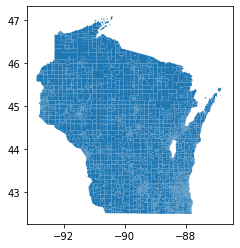

In [14]:
# reading geojson downloaded from opendata portal
wi_gdf = gpd.read_file(r"2012-2020_Election_Data_with_2020_Wards.geojson")
wi_gdf.plot()

In [16]:
# selecting Dane County to perform calculations
dane_county= gdf[(gdf['CNTY_NAME']=='Dane')]
dane_county.head(1)

,OBJECTID,GEOID,CNTY_FIPS,CNTY_NAME,COUSUBFP,MCD_FIPS,MCD_NAME,CTV,LABEL,LSAD,...,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,geometry
818,819,55025008750001,55025,Dane,00875,5502500875,Albion,T,Albion - T 0001,43,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-89.04186 42.86069, -89.04260 42.861..."


Text(0.5, 1.0, 'Election wards 2022 Dane County, WI')

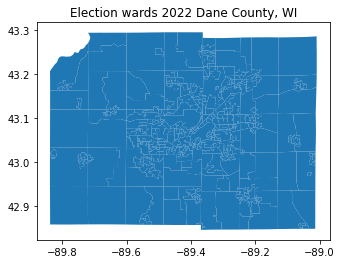

In [20]:
dane_county.plot()
plt.title("Election wards 2022 Dane County, WI")

In [35]:
# replacing all NaN values with zero
dane_county = dane_county.fillna(0)

<b>Variables in each voting district (WARD)</b>
<ul>
<li>Democratic Votes: <b>PREDEM20</b></li>
<li>Republican Votes: <b>PREREP20</b></li>
<li>Total Votes: <b>PRETOT20</b></li>
</ul>

In [73]:
# calculates number of polled votes
def polled_votes(row):
    return (row['PREDEM20'] + row['PREREP20'])

# calculates Democrat voting percentage for a given ward based on polled votes
def dem_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREDEM20']/row['TOTP_VOT'])*100
        return round(result,2)
    else:
        return 0

# calculates Republican voting percentage for a given ward based on polled votes
def rep_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREREP20']/row['TOTP_VOT'])*100
        return round(result,2)
    else: 
        return 0

In [74]:
dane_county['TOTP_VOT'] = dane_county.apply(lambda row: polled_votes(row), axis = 1)
dane_county['DEM_PCT'] = dane_county.apply(lambda row: dem_voters(row), axis = 1)
dane_county['REP_PCT'] = dane_county.apply(lambda row: rep_voters(row), axis = 1)

In [81]:
# calculates Democrat wasted votes for a given ward based on polled votes
def dem_wasted_votes(row):
    if row['DEM_PCT'] >= 50.1:
        excess_pct = (row['DEM_PCT']-50.1)
        if excess_pct > 0:
            wasted_votes = (excess_pct/100)*row['TOTP_VOT']
            return round(wasted_votes)
        else: 
            return 0
    else:
        return 0
    
dane_county['DEM_WST_VOT'] = dane_county.apply(lambda row: dem_wasted_votes(row), axis = 1)

In [83]:
# printing data frame to understand calculations
dane_df = dane_county[['GEOID', 'CNTY_NAME', 'MCD_NAME', 'PREDEM20', 'PREREP20', 'PRETOT20', 'DEM_PCT', 'REP_PCT', 'TOTP_VOT', 'DEM_WST_VOT']]
dane_df

,GEOID,CNTY_NAME,MCD_NAME,PREDEM20,PREREP20,PRETOT20,DEM_PCT,REP_PCT,TOTP_VOT,DEM_WST_VOT
818,55025008750001,Dane,Albion,323.0,288.0,624.0,52.86,47.14,611.0,17
819,55025008750002,Dane,Albion,340.0,302.0,654.0,52.96,47.04,642.0,18
820,55025063000001,Dane,Belleville,443.0,196.0,655.0,69.33,30.67,639.0,123
821,55025063000002,Dane,Belleville,429.0,189.0,630.0,69.42,30.58,618.0,119
822,55025070250001,Dane,Berry,176.0,135.0,316.0,56.59,43.41,311.0,20
...,...,...,...,...,...,...,...,...,...,...
1301,55025515750022,Dane,Middleton,0.0,0.0,0.0,0.00,0.00,0.0,0
1302,55025776750016,Dane,Stoughton,0.0,0.0,0.0,0.00,0.00,0.0,0
1303,55025786000027,Dane,Sun Prairie,0.0,0.0,0.0,0.00,0.00,0.0,0
1304,55025877250010,Dane,Windsor,354.0,202.0,564.0,63.67,36.33,556.0,75


In [89]:
y = dane_county['DEM_WST_VOT'] # target variable
wq =  lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.4855127911687452

Text(0.5, 0, "Moran's I")

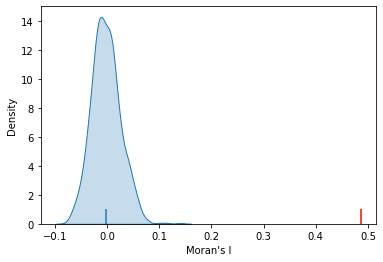

In [92]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r') # observed value
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

### Task 2: Calculation Local Moran's I for Dane County, WI - Hotspots & Coldspots

C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "multilinestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:30: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use th

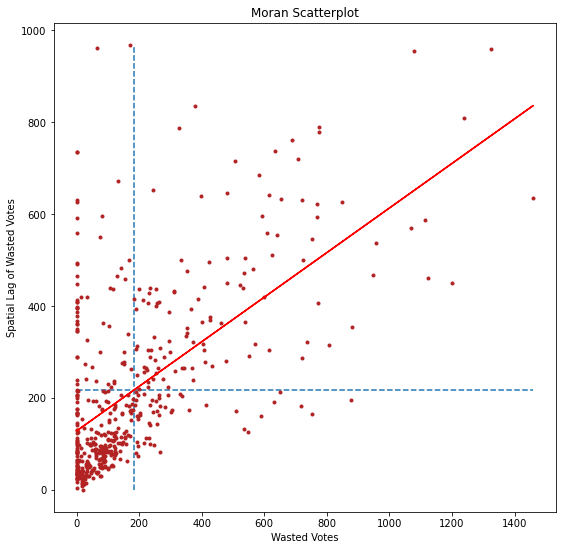

In [95]:
y = dane_county['DEM_WST_VOT'] # target variable
wq = lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
lag_wasted_votes = lps.weights.lag_spatial(wq, dane_county['DEM_WST_VOT'])
wasted_votes = dane_county['DEM_WST_VOT']
b, a = np.polyfit(wasted_votes, lag_wasted_votes, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(wasted_votes, lag_wasted_votes, '.', color='firebrick')

 # dashed vert at mean of wasted votes
plt.vlines(wasted_votes.mean(), lag_wasted_votes.min(), lag_wasted_votes.max(), linestyle='--')
 # dashed horizontal at mean lagged wasted votes
plt.hlines(lag_wasted_votes.mean(), wasted_votes.min(), wasted_votes.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(wasted_votes, a + b*wasted_votes, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Wasted Votes')
plt.xlabel('Wasted Votes')
plt.show()

In [123]:
li = esda.moran.Moran_Local(y, wq)

In [124]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 0, 0, 3, 3, 0, 0, 3, 2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0,
       3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0,
       0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 3, 3, 3, 3, 3,

In [125]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

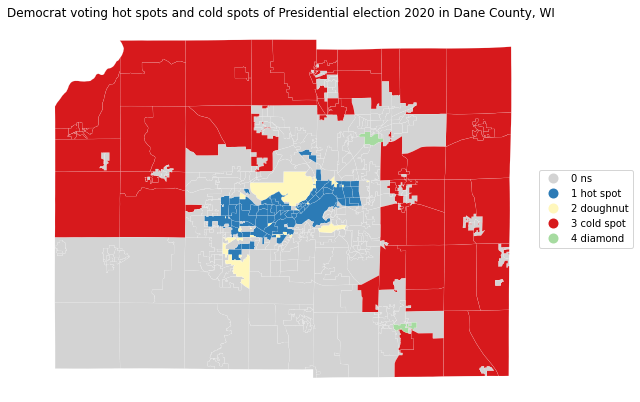

In [146]:
df = dane_county
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', '#2c7bb6', '#fff7bc', '#d7191c', '#a6dba0'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_axis_off()
plt.title('Democrat voting hot spots and cold spots of Presidential election 2020 in Dane County, WI ')
plt.show()